# Pipeline

This pipeline runs training and validation set evaliuation to obtain IoU metrics.

In [2]:
!pip install transformers
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 150.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 215.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 180.3 MB/s eta 0:00:00a 0:00:01
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.2/198.2 kB 225.2 MB/s eta 0:00:00


In [1]:

import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import torch

from train_foundation_features import train_foundation
from train_flood import train_flood
from foundation_eval import foundation_eval, get_eval_results_path
from flood_eval import flood_eval

from postprocessing.roads.wkt_to_G import generate_road_network_graph
from postprocessing.roads.utils import make_logger, rdp

run_root = Path('/tmp/share/runs/spacenet8/nenad')

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_colwidth', None)

def get_params(folder):
    model_path = folder/'best_model.pth'
    model_name = folder.name.split('_lr')[0]
    save_fig_dir = folder/'pngs'
    save_pred_dir = folder/'tiffs'
    return model_path, model_name, save_fig_dir, save_pred_dir

# Data

In [2]:
# # Full dataset
train_csv="/tmp/share/data/spacenet8/sn8_data_train.csv"
val_csv="/tmp/share/data/spacenet8/sn8_data_val.csv"


# Partial dataset to speed up test runs
# train_csv="/tmp/share/data/spacenet8/adrs-small-train.csv"
# val_csv="/tmp/share/data/spacenet8/adrs-small-val.csv"

# Train

Ran foundation and flood network training (uncomment to use):

In [18]:
train_foundation(
      train_csv=train_csv, 
      val_csv=val_csv,
      save_dir=str(run_root/'foundation'),
      model_name='segformer_b0',  # resnet34
      initial_lr=0.0001,
      batch_size=2,
      n_epochs=30,
      gpu=0)

loaded 679 image filepaths
loaded 122 image filepaths


Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_fuse.weight', 'decode_head.linear_c.1.proj.weight', 'decode_head.batch_norm.bias', 'decode_head.batch_norm.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.batch_norm.run

No checkpoint provided. Starting new training ...
EPOCH 0


/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:1945: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


RuntimeError: CUDA out of memory. Tried to allocate 2.52 GiB (GPU 0; 23.88 GiB total capacity; 12.04 GiB already allocated; 729.38 MiB free; 22.24 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [4]:
train_flood(
      train_csv=train_csv, 
      val_csv=val_csv,
      save_dir=str(run_root/'flood'),
      model_name='segformer_b0_siamese',
      initial_lr=0.0001,
      batch_size=2,
      n_epochs=25,
      gpu=0,
      checkpoint_path='/tmp/share/runs/spacenet8/nenad/flood/segformer_b0_siamese_lr1.00e-04_bs2_31-05-2023-19-44/model_checkpoint.pth')

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.classifier.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.batch_norm

loaded 679 image filepaths
loaded 122 image filepaths
Loaded checkpoint.
EPOCH 0
Percentage of used CPU memory: 0.7272426894180098%
Percentage of used CPU memory: 0.7281734717702336%
Percentage of used CPU memory: 0.7281734717702336%
Percentage of used CPU memory: 0.7281734717702336%
Percentage of used CPU memory: 0.7281734717702336%
Percentage of used CPU memory: 0.7281734717702336%
Percentage of used CPU memory: 0.7281734717702336%
Percentage of used CPU memory: 0.7281734717702336%


KeyboardInterrupt: 

In [ ]:
# !python /tmp/share/repos/nenad/baseline/train_foundation_features.py --train_csv /tmp/share/data/spacenet8/sn8_data_train.csv --val_csv /tmp/share/data/spacenet8/sn8_data_val.csv --save_dir /tmp/share/runs/spacenet8/nenad/foundation --model_name resnet34 --lr 0.0001 --batch_size 4 --n_epochs 30 --gpu 0
# !python /tmp/share/repos/nenad/baseline/train_flood.py --train_csv /tmp/share/data/spacenet8/sn8_data_train.csv --val_csv /tmp/share/data/spacenet8/sn8_data_val.csv --save_dir /tmp/share/runs/spacenet8/nenad/flood --model_name resnet34_siamese --lr 0.0001 --batch_size 2 --n_epochs 30 --gpu 0

# Evaluation

We run evaluation on validation data to generate tiff images (segmentation masks) and pngs (for visualization). Note: these are geotiff images (not tiff), and to load them one must use osgeo.gdal (see `SN8Dataset.__getitem__`). 

- building segmentation mask (geotiff) has 1 or 0 for building
- flood segmentation mask has: 0 for background, 1 non-flooded building, 2 is flooded building, 3 is non-flooded road, 4 is flooded road


We first run eval for foundation model:

In [ ]:
# # resnet34
# foundation_run_folder = run_root/'foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13'
# flood_run_folder = '/tmp/share/runs/spacenet8/nenad/flood/resnet34_siamese_lr1.00e-04_bs2_11-05-2023-10-48'

In [5]:
# segformer_b0
foundation_run_folder = run_root/'foundation/segformer_b0_lr1.00e-04_bs2_31-05-2023-13-25'
flood_run_folder = run_root/'flood/segformer_b0_siamese_lr1.00e-04_bs2_31-05-2023-19-44'

In [20]:
model_path, model_name, save_fig_dir, save_pred_dir = get_params(foundation_run_folder)
foundation_eval(model_path=model_path, 
                in_csv=val_csv, 
                save_fig_dir=save_fig_dir,
                save_preds_dir=save_pred_dir,
                model_name=model_name)
model_path, model_name, save_fig_dir, save_pred_dir = get_params(flood_run_folder)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.bias', 'decode_head.classifier.weight', 'decode_head.classifier.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.0.proj.b

loaded 9 image filepaths
Saving results to /tmp/share/runs/spacenet8/nenad/foundation/segformer_b0_lr1.00e-04_bs2_31-05-2023-13-25/eval_results.csv
evaluating:  0 10500500C4DD7000_0_16_63.tif
evaluating:  1 105001001A0FFC00_0_12_14.tif
evaluating:  2 10400100684A4B00_1_10_82.tif
evaluating:  3 10400100684A4B00_1_12_92.tif
evaluating:  4 10400100684A4B00_1_12_106.tif
evaluating:  5 10500500C4DD7000_0_29_70.tif
evaluating:  6 10500500C4DD7000_0_41_63.tif
evaluating:  7 105001001A0FFC00_0_12_5.tif
evaluating:  8 10500500C4DD7000_0_33_61.tif

final metrics for: building
final running evaluation score: 
precision:  0.0
recall:  0.0
f1:  0.0
iou:  0.0

final metrics for: road
final running evaluation score: 
precision:  0.17307691475591755
recall:  0.00016015944762073534
f1:  0.0003200042851014302
iou:  0.00016003698631861422



and then for flood model:

In [6]:
model_path, model_name, save_fig_dir, save_pred_dir = get_params(flood_run_folder)
flood_eval(model_path=model_path, 
           in_csv=val_csv, 
           save_fig_dir=save_fig_dir,
           save_preds_dir=save_pred_dir,
           model_name=model_name)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.classifier.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.batch_norm

loaded 122 image filepaths
Saving results to /tmp/share/runs/spacenet8/nenad/flood/segformer_b0_siamese_lr1.00e-04_bs2_31-05-2023-19-44/eval_results.csv
evaluating:  0 10500500C4DD7000_0_16_63.tif
evaluating:  1 105001001A0FFC00_0_12_14.tif
evaluating:  2 10400100684A4B00_1_10_82.tif
evaluating:  3 10400100684A4B00_1_12_92.tif
evaluating:  4 10400100684A4B00_1_12_106.tif
evaluating:  5 10500500C4DD7000_0_29_70.tif
evaluating:  6 10500500C4DD7000_0_41_63.tif
evaluating:  7 105001001A0FFC00_0_12_5.tif
evaluating:  8 10500500C4DD7000_0_33_61.tif
evaluating:  9 105001001A0FFC00_0_16_14.tif
evaluating:  10 10400100684A4B00_1_12_87.tif
evaluating:  11 10400100684A4B00_1_4_90.tif
evaluating:  12 10400100684A4B00_1_7_89.tif
evaluating:  13 10400100684A4B00_1_22_70.tif
evaluating:  14 105001001A0FFC00_0_15_9.tif
evaluating:  15 10400100684A4B00_1_15_86.tif
evaluating:  16 10400100684A4B00_1_9_88.tif
evaluating:  17 10400100684A4B00_1_24_77.tif
evaluating:  18 105001001A0FFC00_0_17_15.tif
evalua

In [5]:
flood_run_folder = '/tmp/share/runs/spacenet8/nenad/flood/resnet34_siamese_lr1.00e-04_bs2_11-05-2023-10-48'
model_path = os.path.join(flood_run_folder, 'best_model.pth')
in_csv = '/tmp/share/data/spacenet8/sn8_data_val.csv'
save_fig_dir = os.path.join(flood_run_folder, 'pngs')
save_preds_dir = os.path.join(flood_run_folder, 'tiffs')
model_name = 'resnet34_siamese'

In [ ]:
# run_flood_eval(model_path=model_path, 
#                in_csv=in_csv, 
#                save_fig_dir=save_fig_dir, 
#                save_preds_dir=save_preds_dir, 
#                model_name=model_name)

In [12]:
import models.other.segformer as segformer


model_path = '/tmp/share/runs/spacenet8/nenad/flood/segformer_b0_siamese_lr1.00e-04_bs2_31-05-2023-19-44/best_model.pth'
model =segformer.SiameseSegformer_b0(num_classes=5, num_channels=3)


Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.classifier.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.batch_norm

In [13]:
model

SiameseSegformer_b0(
  (segformer): SegformerForSemanticSegmentation(
    (segformer): SegformerModel(
      (encoder): SegformerEncoder(
        (patch_embeddings): ModuleList(
          (0): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
            (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          )
          (1): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          )
          (2): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
          )
          (3): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          

In [14]:

model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [18]:
list(model.named_parameters())

[('segformer.segformer.encoder.patch_embeddings.0.proj.weight',
  Parameter containing:
  tensor([[[[-1.3429e-03, -9.0352e-04, -3.8551e-03,  ..., -1.9987e-02,
             -1.7569e-02, -2.5025e-03],
            [-4.0656e-03, -5.2134e-03, -2.3828e-02,  ..., -6.5525e-03,
             -9.8634e-03,  9.3339e-03],
            [-1.6274e-02, -3.0260e-02, -7.0867e-02,  ...,  9.2905e-02,
              2.1842e-02,  1.7443e-02],
            ...,
            [-3.8424e-02, -6.9336e-02, -2.0720e-02,  ...,  3.1213e-02,
              2.3435e-02,  5.6041e-02],
            [-2.3371e-02, -3.6436e-02,  1.2990e-02,  ...,  1.1474e-01,
              1.0874e-01,  6.1956e-02],
            [-1.0839e-02, -2.5660e-03,  4.7630e-02,  ...,  3.4258e-02,
             -2.2794e-02,  1.4798e-02]],
  
           [[ 2.5127e-03,  1.9721e-03,  3.9223e-03,  ...,  8.8608e-03,
              3.5430e-03,  6.2607e-03],
            [ 5.3715e-03,  1.1350e-03,  6.4571e-03,  ...,  3.1886e-02,
              1.6067e-02, -7.8250e-03],
   

In [20]:
tt = torch.rand((1, 3, 1300, 1300))
out = model(tt, tt)
out.shape

torch.Size([1, 5, 1300, 1300])

# Plot metrics

The logs containing IoUs are logged in the eval_results.csv:

In [52]:
df_foundation = pd.read_csv(os.path.join(foundation_run_folder, 'eval_results.csv'))
df_flood = pd.read_csv(os.path.join(flood_run_folder, 'eval_results.csv'))

In [53]:
df_foundation

,datetime,model_name,type,precision,recall,f1,iou
0,20230524_232758,resnet34,building,0.824575,0.685690,0.748742,0.598397
1,20230524_232758,resnet34,road,0.692888,0.688146,0.690504,0.527311


In [54]:
df_flood

,datetime,model_name,class,precision,recall,f1,iou
0,20230525_054013,resnet34_siamese,non-flooded building,0.723200,0.697050,0.709879,0.550249
1,20230525_054013,resnet34_siamese,flooded building,0.570866,0.482779,0.523136,0.354225
2,20230525_054013,resnet34_siamese,non-flooded road,0.636372,0.616443,0.626244,0.455868
3,20230525_054013,resnet34_siamese,flooded road,0.618929,0.438913,0.513599,0.345536


Let's focus on buildings only and plot IoUs:

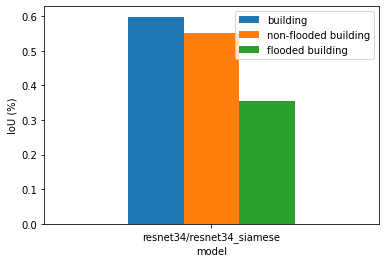

In [55]:
d = [{'model': 'resnet34/resnet34_siamese', 'building': 0.598397, 'non-flooded building': 0.550249, 'flooded building': 0.354225}]
df_result = pd.DataFrame(d)
df_result.set_index('model', inplace=True)

df_result.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('IoU (%)')
plt.gcf()
plt.show()


PNG image is for visalization, combines buidlings and roads:

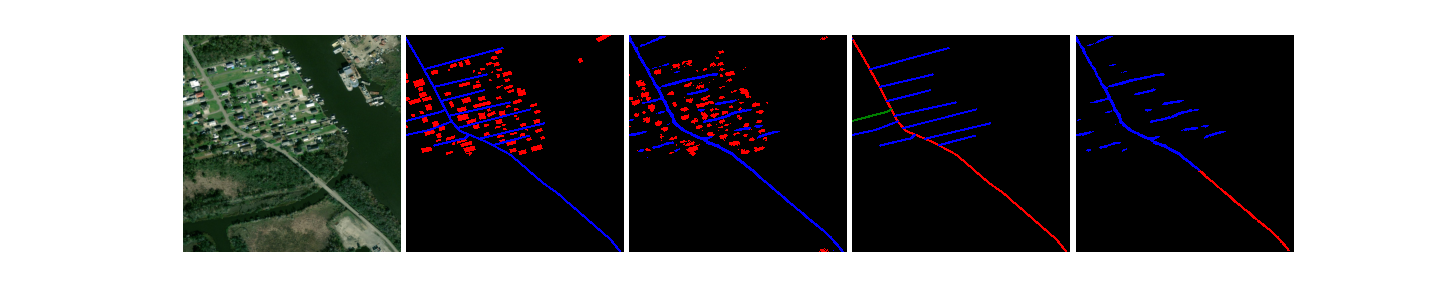

In [63]:
im = os.path.join(run_root, 'foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/pngs/10300100AF395C00_2_16_51_pred.png')
image = Image.open(im)
image


Having IoUs is not ideal metric, a more meaningful result in practice would be report whether buidling or road is flooded. To do this we need postprocessing step. I was able to produce postprocessing ster for buildings but stuggling to do the same for roads and running into a bug. More on this in Appendix below.

# Appendix

# Postprocessing

I was able to generate `buidling_submission.csv` and what is currently missing is to compare this file to a reference files '/tmp/share/data/spacenet8/Germany_Training_Public/Germany_Training_Public_reference.csv' and '/tmp/share/data/spacenet8/Louisiana-East_Training_Public/Louisiana-East_Training_Public_reference, specifically the ones that are used in validation set. It is currenly not clear to me how to do this.

## Buildings

These are the steps that are done behind the scenes in building postoprocessing:
- morphological opening is done on a building segmentation image, not flood image,
- to determine if the building was flooded an overlap of flood segmentation mask and building segmentation mask is done, with overlap of perc_positive (i.e. means "any blob with number of flood pixels above this percentage, will be classified as fully flooded. otherwise it is not flooded")
- poligonization converts mask to a osgeo.ogr.DataSource (some compact raster format),
- some fancy `remove_small_polygons_and_simplify` simlifies the pologon, it's all using `osgeo` library,
- `save_to_shapefile` saves 5 files (cpg, dbf, prj, shp, shx) per one tiff image, have no idea what these are
- every buidling object is then written line by line in a `building_submission.csv` file.

One can run all of the steps in the following section (I had to manually create `building_preds/pred_shps` folder):

In [59]:
from postprocessing.buildings.building_postprocessing import main_w_flood

In [61]:
out_submission_csv = os.path.join(run_root, 'building_preds/building_submission.csv')
out_shapefile_dir = os.path.join(run_root, 'building_preds/pred_shps')  # have to manually make these dirs

square_size = 5 
simplify_tolerance = 0.75
min_area = 5
percent_positive = 0.5

main_w_flood(os.path.join(foundation_run_folder, 'tiffs'),
             os.path.join(flood_run_folder, 'tiffs'),
             out_submission_csv,
             out_shapefile_dir,
             square_size,
             min_area,
             simplify_tolerance,
             percent_positive)

postprocessing 122 tiles
100.0%  


This created `/tmp/share/runs/spacenet8/nenad/building_preds/building_submission.csv` 

Let's look at the building submissions csv file:

In [62]:
df = pd.read_csv('/tmp/share/runs/spacenet8/nenad/building_preds/building_submission.csv', na_values=['Null'], dtype={'Flooded': 'boolean'})
df.tail()

,ImageId,Object,Flooded,Wkt_Pix,Wkt_Geo
2179,10400100684A4B00_1_17_75,Building,False,"POLYGON ((173 1130, 168 1133, 167 1143, 160 1142, 159 1158, 165 1160, 165 1163, 181 1165, 188 1173, 195 1174, 200 1177, 209 1177, 211 1173, 213 1173, 213 1165, 223 1162, 218 1147, 204 1145, 192 1132, 173 1130))","POLYGON ((-89.9798666468652 29.878899952489,-89.9798838945187 29.8788896038969,-89.97989079358 29.87885510859,-89.9799114907642 29.8788585581207,-89.9799149402949 29.8788068151603,-89.9798976926414 29.8787999160989,-89.9798976926414 29.8787895675068,-89.9798390506197 29.8787792189148,-89.9798183534355 29.8787550721999,-89.97979075719 29.8787516226692,-89.9797769590672 29.8787378245465,-89.979745913291 29.8787378245465,-89.9797390142296 29.8787550721999,-89.9797286656376 29.8787550721999,-89.9797286656376 29.8787792189148,-89.9796976198613 29.8787930170375,-89.9797114179841 29.8788447599979,-89.9797597114138 29.8788482095286,-89.9798011057821 29.8788930534276,-89.9798666468652 29.878899952489))"
2180,10400100684A4B00_1_17_75,Building,False,"POLYGON ((304 1170, 284 1177, 283 1197, 288 1197, 288 1201, 299 1201, 300 1205, 316 1206, 317 1201, 323 1200, 326 1178, 323 1178, 317 1171, 304 1170))","POLYGON ((-89.9794147583447 29.878765420792,-89.9794837489585 29.8787378245465,-89.9794871984892 29.8786688339327,-89.9794734003664 29.8786688339327,-89.9794734003664 29.8786550358099,-89.9794354555288 29.8786550358099,-89.9794320059981 29.8786446872178,-89.9793733639764 29.8786412376871,-89.9793699144457 29.8786550358099,-89.9793526667922 29.8786584853406,-89.9793388686695 29.8787343750158,-89.9793526667922 29.8787343750158,-89.9793699144457 29.8787619712613,-89.9794147583447 29.878765420792))"
2181,10400100684A4B00_1_17_75,Building,False,"POLYGON ((445 1258, 439 1260, 433 1275, 433 1290, 437 1292, 437 1299, 468 1299, 468 1295, 475 1295, 475 1290, 482 1288, 481 1276, 466 1273, 466 1266, 458 1263, 455 1259, 445 1258))","POLYGON ((-89.9789318240479 29.8784618620912,-89.9789490717014 29.8784549630298,-89.9789732184162 29.8783997705388,-89.9789732184162 29.8783480275784,-89.9789594202934 29.8783445780477,-89.9789594202934 29.8783169818022,-89.978852484842 29.8783169818022,-89.9788490353114 29.878330779925,-89.9788248885965 29.8783342294556,-89.9788248885965 29.8783480275784,-89.9788007418817 29.8783549266398,-89.978807640943 29.8783963210081,-89.9788593839034 29.8784101191308,-89.9788593839034 29.878430816315,-89.9788869801489 29.8784411649071,-89.978897328741 29.8784584125605,-89.9789318240479 29.8784618620912))"
2182,10400100684A4B00_1_5_97,Building,False,"POLYGON ((1262 141, 1262 149, 1280 152, 1275 141, 1262 141))","POLYGON ((-90.0299227867226 29.7836584101099,-90.0299227867226 29.7836308138644,-90.0298641447008 29.7836204652723,-90.0298779428236 29.7836584101099,-90.0299227867226 29.7836584101099))"
2183,10400100684A4B00_1_5_97,Building,False,"POLYGON ((1235 923, 1226 944, 1228 963, 1234 967, 1258 969, 1264 965, 1265 949, 1271 946, 1272 933, 1261 930, 1261 925, 1253 925, 1251 923, 1235 923))","POLYGON ((-90.0300193735819 29.7809608771095,-90.0300504193581 29.780888436965,-90.0300400707661 29.7808228958819,-90.0300228231126 29.7808056482285,-90.029940034376 29.7807987491671,-90.0299158876612 29.7808159968205,-90.0299124381305 29.7808677397809,-90.029895190477 29.780878088373,-90.0298882914157 29.7809263818026,-90.0299262362533 29.7809367303947,-90.0299296857839 29.7809505285175,-90.0299538324988 29.7809505285175,-90.0299607315602 29.7809608771095,-90.0300193735819 29.7809608771095))"


Each row is one building with Wkt_Geo coordiantes. Let's look at some flooded buildings:


In [ ]:
df_flooded = df[df['Flooded'] == True]
df_flooded.head()

,ImageId,Object,Flooded,Wkt_Pix,Wkt_Geo
57,105001001A0FFC00_0_12_5,Building,True,"POLYGON ((470 115, 466 118, 466 124, 464 124, 463 135, 456 135, 456 144, 470 144, 472 148, 482 148, 485 144, 496 141, 496 132, 486 131, 483 127, 481 127, 481 118, 470 115))","POLYGON ((-90.0079539783815 29.7248743126759,-90.007967789979 29.7248605010784,-90.007967789979 29.7248374817492,-90.0079769977107 29.7248374817492,-90.0079862054423 29.7247868392251,-90.0080138286373 29.7247822353593,-90.0080138286373 29.7247454044326,-90.0079493745157 29.7247454044326,-90.0079447706498 29.7247223851035,-90.0078941281257 29.7247223851035,-90.007884920394 29.7247408005668,-90.0078296740041 29.7247592160301,-90.0078296740041 29.7247960469568,-90.0078757126624 29.7248052546884,-90.0078895242599 29.7248236701517,-90.0079033358573 29.7248236701517,-90.0079033358573 29.7248651049442,-90.0079539783815 29.7248743126759))"
104,105001001A0FFC00_0_15_9,Building,True,"POLYGON ((850 83, 850 84, 837 87, 834 90, 834 100, 848 99, 848 96, 850 99, 858 99, 858 96, 864 97, 867 94, 867 83, 850 83))","POLYGON ((-89.9882448287585 29.7010861379265,-89.9882448287585 29.7010769301949,-89.9883046790143 29.7010677224632,-89.9883230944776 29.7010539108657,-89.9883230944776 29.7010078722074,-89.9882540364902 29.7010124760732,-89.9882540364902 29.7010216838049,-89.9882448287585 29.7010124760732,-89.9882079978319 29.7010124760732,-89.9882079978319 29.7010216838049,-89.9881803746369 29.7010170799391,-89.9881665630394 29.7010308915366,-89.9881665630394 29.7010861379265,-89.9882448287585 29.7010861379265))"
107,105001001A0FFC00_0_15_9,Building,True,"POLYGON ((1281 343, 1269 350, 1272 364, 1277 364, 1279 373, 1296 376, 1297 370, 1300 370, 1300 350, 1298 347, 1287 345, 1287 343, 1281 343))","POLYGON ((-89.9862651664511 29.6998891328104,-89.9863158089753 29.6998523018838,-89.9863019973778 29.6997878477622,-89.9862835819144 29.6997878477622,-89.986269770317 29.6997464129697,-89.9861961084636 29.6997326013722,-89.9861915045978 29.699764828433,-89.9861776930003 29.699764828433,-89.9861776930003 29.6998569057496,-89.9861822968662 29.6998661134813,-89.9862329393903 29.699875321213,-89.9862375432561 29.6998891328104,-89.9862651664511 29.6998891328104))"
108,105001001A0FFC00_0_15_9,Building,True,"POLYGON ((885 444, 885 449, 892 448, 892 444, 885 444))","POLYGON ((-89.9880882973202 29.6994241423615,-89.9880882973202 29.6994011230323,-89.9880560702594 29.6994011230324,-89.9880560702594 29.6994241423615,-89.9880882973202 29.6994241423615))"
223,105001001A0FFC00_0_17_15,Building,True,"POLYGON ((465 267, 456 267, 456 271, 446 274, 445 280, 447 280, 445 280, 445 286, 446 285, 446 290, 449 290, 452 296, 455 296, 456 300, 468 300, 468 302, 474 302, 478 290, 481 290, 484 277, 481 274, 474 276, 472 267, 465 267))","POLYGON ((-89.9780518698084 29.6643288731309,-89.9780887007351 29.6643242692651,-89.9780887007351 29.6643104576676,-89.9781393432592 29.6642966460701,-89.978143947125 29.6642690228751,-89.9781301355276 29.6642644190093,-89.978143947125 29.6642644190093,-89.978143947125 29.6642413996801,-89.9781347393934 29.6642413996802,-89.9781347393934 29.6642229842168,-89.9781209277959 29.6642229842168,-89.9781117200642 29.664190757156,-89.9780933046009 29.664190757156,-89.9780887007351 29.6641723416927,-89.9780380582109 29.6641769455585,-89.9780380582109 29.6641677378268,-89.9780104350159 29.6641677378268,-89.9779920195526 29.664218380351,-89.9779782079551 29.664218380351,-89.9779643963576 29.6642828344726,-89.9779782079551 29.6642920422043,-89.9780104350159 29.6642874383384,-89.9780150388818 29.6643288731309,-89.9780518698084 29.6643288731309),(-89.9780104350159 29.6642644190093,-89.9780104350159 29.6642598151435,-89.9780058311501 29.6642598151435,-89.9780058311501 29.6642644190093,-89.9780104350159 29.6642644190093))"


There are 428 flooded buildings in the 

In [ ]:
len(df_flooded)

428

In [ ]:
df_flooded.iloc[0]['Wkt_Geo']

'POLYGON ((-90.0079539783815 29.7248743126759,-90.007967789979 29.7248605010784,-90.007967789979 29.7248374817492,-90.0079769977107 29.7248374817492,-90.0079862054423 29.7247868392251,-90.0080138286373 29.7247822353593,-90.0080138286373 29.7247454044326,-90.0079493745157 29.7247454044326,-90.0079447706498 29.7247223851035,-90.0078941281257 29.7247223851035,-90.007884920394 29.7247408005668,-90.0078296740041 29.7247592160301,-90.0078296740041 29.7247960469568,-90.0078757126624 29.7248052546884,-90.0078895242599 29.7248236701517,-90.0079033358573 29.7248236701517,-90.0079033358573 29.7248651049442,-90.0079539783815 29.7248743126759))'

Let's load reference csv files:

In [ ]:
ref1 = pd.read_csv('/tmp/share/data/spacenet8/Germany_Training_Public/Germany_Training_Public_reference.csv', na_values=['Null'], dtype={'Flooded': 'boolean'})
ref2 = pd.read_csv('/tmp/share/data/spacenet8/Louisiana-East_Training_Public/Louisiana-East_Training_Public_reference.csv', na_values=['Null'], dtype={'Flooded': 'boolean'})
ref = pd.concat([ref1, ref2])
ref.head()

,ImageId,Object,Wkt_Pix,Flooded,length_m,travel_time_s
0,10500500C4DD7000_0_44_69,Road,LINESTRING EMPTY,<NA>,NaN,NaN
1,10500500C4DD7000_0_37_69,Road,"LINESTRING (1300.0000000000637 125.11088048440429, 1264.8329929537006 119.92324021553506)",False,9.594786,0.715431
2,10500500C4DD7000_0_37_69,Road,"LINESTRING (1264.8329929537006 119.92324021553506, 1170.2292368980147 103.03829985213261)",False,26.113182,1.947117
3,10500500C4DD7000_0_37_69,Road,"LINESTRING (1170.2292368980147 103.03829985213261, 1153.0236964009407 101.67574928408781)",False,4.608716,0.343647
4,10500500C4DD7000_0_37_69,Road,"LINESTRING (1153.0236964009407 101.67574928408781, 1042.6838171267377 67.02421819128786)",False,32.691009,2.437590


We now need to compare building predicitons csv file with the reference csv files in a validation set:

In [ ]:
ref_building = ref[ref['Object'] == 'Building']
ref_building.head()


,ImageId,Object,Wkt_Pix,Flooded,length_m,travel_time_s
5702,10500500C4DD7000_0_28_64,Building,"POLYGON ((927.5803811493666 521.0667509071188, 903.2147710045658 517.192832627805, 907.3558560620578 506.6130282225759, 931.7214662068587 510.4869465018897, 927.5803811493666 521.0667509071188))",True,NaN,NaN
5703,10500500C4DD7000_0_28_64,Building,"POLYGON ((1042.8628458148846 482.9420517008487, 1037.0653267342534 498.4110081418996, 1000.890945006217 492.9608058716187, 1006.6617474087457 477.4651327543636, 1042.8628458148846 482.9420517008487))",True,NaN,NaN
5704,10500500C4DD7000_0_28_64,Building,"POLYGON ((1058.3050855775957 370.81215501418006, 1031.4281077205767 370.57170491505354, 1031.6952744985176 358.04158303111626, 1058.5722523555366 358.2820331302428, 1058.3050855775957 370.81215501418006))",True,NaN,NaN
5705,10500500C4DD7000_0_28_64,Building,"POLYGON ((1092.7963166051022 111.36649699168625, 1094.2390172055564 124.1103522985458, 1066.453672303728 125.39275283228288, 1065.0109717030364 112.62218084921906, 1092.7963166051022 111.36649699168625))",True,NaN,NaN
5706,10500500C4DD7000_0_28_64,Building,"POLYGON ((1079.9455945877307 151.49494703286962, 1077.915127075664 158.41456658170725, 1056.7822349435455 155.92991554664252, 1058.8127024556125 148.98357932160067, 1079.9455945877307 151.49494703286962))",True,NaN,NaN


Can we find a building in the reference csv file that is close to the building in the predictions csv file? This is not an easy task.

## Roads

I'm running into issue with road postprocessing (see below):

In [ ]:
# !python baseline/postprocessing/roads/vectorize_roads.py --im_dir /tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/tiffs --out_dir /tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/road_preds --write_shps --write_graphs --write_csvs --write_skeletons

number of prediction images to vectorize:  107
output shapefile dir:  /tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/road_preds/sknw_shps
output graph dir:  /tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/road_preds/sknw_graphs
output csv dir:  /tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/road_preds/sknw_csvs
output skeleton dir:  /tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/road_preds/skeletons
Executing make_skeleton...
1300
1300
(1300, 1300)
1690000
Run preprocess() with skimage
Time to run preprocess(): 0.05678963661193848 seconds
skeletonize...
Time to run skimage.skeletonize(): 0.04388785362243652 seconds
ske.shape: (1300, 1300)
Time to run make_skeleton: 0.17720818519592285 seconds
Execute sknw...
35 random node props: {'pts': array([[1152, 1295]], dtype=int16), 'o': array([1152., 1295.])}
Clean out small terminals - round 0
Clean

The following is not running properly:

In [26]:
root = '/tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/road_preds'
generate_road_network_graph(wkt_submission=os.path.join(root, 'sknw_wkt.csv'),
                            graph_dir=os.path.join(root, 'graphs_nospeed'),
                            log_file=os.path.join(root, 'wkt_to_G.log'),
                            min_subgraph_length_pix=20,
                            min_spur_length_m=10)


log     : INFO     df_wkt at: /tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/road_preds/sknw_wkt.csv
log     : INFO     df_wkt at: /tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/road_preds/sknw_wkt.csv
log     : INFO     df_wkt at: /tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/road_preds/sknw_wkt.csv


['/tmp/share/repos/nenad/baseline', '/opt/conda/lib/python38.zip', '/opt/conda/lib/python3.8', '/opt/conda/lib/python3.8/lib-dynload', '', '/opt/conda/lib/python3.8/site-packages', '/opt/conda/lib/python3.8/site-packages/torchtext-0.12.0a0-py3.8-linux-x86_64.egg']
image_ids: ['/tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/tiffs/10300100AF395C00_2_13_45_roadspeedpred.tif'
 '/tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/tiffs/10300100AF395C00_2_15_44_roadspeedpred.tif'
 '/tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/tiffs/10300100AF395C00_2_15_49_roadspeedpred.tif'
 '/tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/tiffs/10300100AF395C00_2_16_44_roadspeedpred.tif'
 '/tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/tiffs/10300100AF395C00_2_16_51_roadspeedpred.tif'
 '/tmp/share/runs/spacenet8/nenad/foundation

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


ValueError: Geometry must be unprojected to calculate UTM zone

no point in attempting the next step:

In [ ]:
# !python infer_speed.py --eval_csv /tmp/share/runs/spacenet8/nenad/sn8_data_val.csv --mask_dir /tmp/share/runs/spacenet8/nenad/foundation/resnet34_lr1.00e-04_bs4_11-05-2023-08-13/tiffs/road_preds --graph_dir $GRAPH_NO_SPEED_DIR --graph_speed_dir $GRAPH_SPEED_DIR --log_file $INFER_SPEED_LOG_FILE

In [87]:
df_flooded.iloc[0]['Wkt_Pix'] in ref_building['Wkt_Pix'].values

False

The `ref` will have all data (train and valid), we need to get only validation data:

In [98]:
valid_df = pd.read_csv('/tmp/share/runs/spacenet8/nenad/sn8_data_val.csv')

In [104]:
valid_df.iloc[0]

preimg                         /tmp/share/data/spacenet8/Germany_Training_Public/PRE-event/10500500C4DD7000_0_16_63.tif
postimg                       /tmp/share/data/spacenet8/Germany_Training_Public/POST-event/10500500E6DD3C00_0_16_63.tif
flood            /tmp/share/data/spacenet8/Germany_Training_Public/annotations/masks/flood_10500500C4DD7000_0_16_63.tif
building      /tmp/share/data/spacenet8/Germany_Training_Public/annotations/masks/building_10500500C4DD7000_0_16_63.tif
road              /tmp/share/data/spacenet8/Germany_Training_Public/annotations/masks/road_10500500C4DD7000_0_16_63.tif
roadspeed    /tmp/share/data/spacenet8/Germany_Training_Public/annotations/masks/roadspeed_10500500C4DD7000_0_16_63.tif
Name: 0, dtype: object